In [1]:
%load_ext autoreload
%autoreload 2

import os
from os import listdir
from os.path import isfile, join

import numpy as np
import matplotlib.pyplot as plt
import madmom

import sys
sys.path.append('../src')
from preprocessing import get_dataset, load_rhythm_feature_db
from models import OLSPatchRegressor
from utils import cv
import visualize

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import Model
from sklearn.metrics import log_loss

MUSIC = 1
SPEECH = 0

na = np.newaxis

plt.rc('text', usetex=True)
plt.rc('font', family='serif')


# --------------- FLAGS ----------
DATA = "SPECTRO" # "SPECTRO"
MODEL = "CNN" # "Linear"

assert DATA in ["RHYTHM", "SPECTRO"]
assert MODEL in ["CNN", "Linear"]



/home/niels/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
music_dir  = '../data/music_speech/music_wav/'
speech_dir = '../data/music_speech/speech_wav/'


def get_spectro_data():

    max_samples = -1

    X, Y = get_dataset(music_dir, speech_dir, hpool=0, wpool=0, 
                       num_samples=max_samples, shuffle=True, reload=False,
                       window=np.hanning, fps=100, num_bands=3, fmin=30, fmax=17000,
                       fft_sizes=[1024, 2048, 4096]
                      )
    print('Train Set Shape')
    print(X.shape, Y.shape)

    Y = (Y + 1) / 2 
    return X, Y
 

def get_rhythm_data():

    X, Y = load_rhythm_feature_db(music_dir, speech_dir, num_samples=-1)

    # change -1, 1 labels to 0,1
    Y = (Y + 1) / 2 

    # X is in (N,L,D) format

    X = X[:,na,:,:] # dont conv over the number of models
    return X, Y

X, Y = get_rhythm_data() if DATA == "RHYTHM" else get_spectro_data()

batch_size = 8
num_classes = 2
epochs = 50

# --------------------------------------------
num_frequencies = X.shape[1]
num_timesteps   = X.shape[2]
num_channels    = X.shape[3]
filter_time_size = 3
input_shape = num_frequencies, num_timesteps, num_channels

loaded from disk: -data-music_speech-music_wav--data-music_speech-speech_wav-_raw
Train Set Shape
(128, 24, 3000, 3) (128,)


In [3]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

CNN = None
def get_cnn(input_shape=(input_shape), reinit=False):
    global CNN
    if CNN is None:
        
        # DEFINE MODEL
        model = Sequential()
        model.add(MaxPooling2D(pool_size=(1, 3), input_shape=input_shape))
        model.add(Conv2D(32, kernel_size=(num_frequencies, filter_time_size),
                         activation='relu'))

        model.add(Conv2D(1, kernel_size=(1, 1), activation='sigmoid'))
        model.add(Lambda(lambda x: K.mean(x, axis=[1,2])))

        model.compile(loss=keras.losses.binary_crossentropy,
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy'])
        
        CNN = model
        
        return model
    
    else:
        model = CNN
        reset_weights(model)
        return model

LINEAR = None
def get_linear(input_shape=(input_shape), reinit=False):
    global LINEAR
    if LINEAR is None:
        
        # DEFINE MODEL
        model = Sequential()
        model.add(Conv2D(1, kernel_size=(num_frequencies, filter_time_size),
                         activation='sigmoid',
                         input_shape=input_shape))

        model.add(Lambda(lambda x: K.mean(x, axis=[1,2])))

        model.compile(loss=keras.losses.binary_crossentropy,
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy'])
        
        LINEAR = model
        
        return model
    
    else:
        model = LINEAR
        reset_weights(model)
        return model

get_model = get_cnn if MODEL == "CNN" else get_linear

In [4]:
# cross validation

train_model = lambda model, X, Y: model.fit(X, Y,
                                        batch_size=batch_size,
                                        epochs=epochs,
                                        verbose=0)

# evaluate using cross-validation on training set
#cvacc = cv(X, Y, get_model, train_model, nfolds=5, nrepetitions=1)
#print('CV loss:', cvacc[0])
#print('CV accuracy:', cvacc[1])

In [5]:
split = 100
Xtrain, Ytrain, Xtest, Ytest = X[:split], Y[:split], X[split:], Y[split:]
# evaluate using train-test split
model = get_model()
train_model(model, Xtrain, Ytrain)
score = model.evaluate(Xtest, Ytest, verbose=0)
model_path = '../models/keras/'
os.makedirs(model_path, exist_ok=True)

model.save(os.path.join(model_path, '{}_on_{}-{:2.2f}.h5'.format(MODEL, DATA, score[1])))

Y_p (2, 998)
y_time (998,)


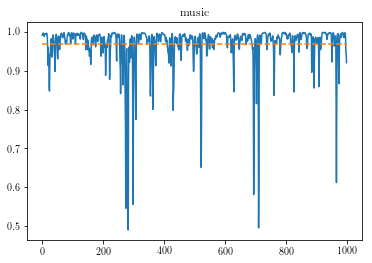

y_time (998,)


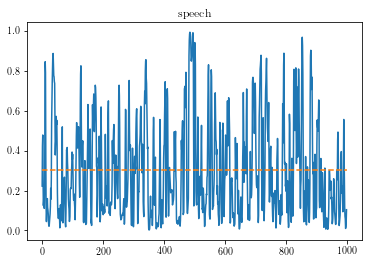

music (24, 3000, 3)
w_speech (1, 3000, 1)
audio (24, 3000, 3)
y (998,)


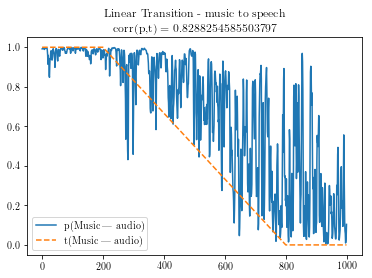

In [9]:
music = Xtest[Ytest == MUSIC][0]
speech = Xtest[Ytest == SPEECH][1]
visualize.prediction_over_time(music, speech, model)

In [ ]:
# for the original model, estimate the probability of a correct classification using chebychevs inequality

X_p, Y_p, X_n, Y_n = Xtest[Ytest>0], Ytest[Ytest>0], Xtest[Ytest<=0], Ytest[Ytest<=0]
time_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
prediction_p = time_model.predict(X_p)[:,0,:,0]
prediction_n = time_model.predict(X_n)[:,0,:,0]

mean_p, var_p = np.mean(prediction_p), np.mean(np.var(prediction_p, axis=1))
mean_n, var_n = np.mean(prediction_n), np.mean(np.var(prediction_n, axis=1))
var_p *= (len(Y_p)/(len(Y_p)-1))
var_n *= (len(Y_n)/(len(Y_n)-1))

print("var p, var n", var_p, ", ", var_n)
print("mean of positive samples", mean_p)
print("mean of negative samples", mean_n)

def p_wrong_negative(num_timestamps):
    # p(prediction is negative but sample is positive)
    diff = mean_p - 0.5
    std = np.sqrt(var_p/num_timestamps)
    k = diff/std
    return min(1/k/k, 0.5)

def p_wrong_positive(num_timestamps):
    diff =  0.5 - mean_n
    std = np.sqrt(var_n/num_timestamps)
    k = diff/std
    return min(1/k/k, 0.5)

s_per_timestamp = 30/X.shape[2]
time = np.arange(0, 10, s_per_timestamp*5)
max_t = len(time)

plt.plot(time, [p_wrong_negative(i*5) for i in range(max_t)], label="Wrong negative")
plt.plot(time, [p_wrong_positive(i*5) for i in range(max_t)], ".", label="Wrong positive")
plt.legend()
plt.show()

"""
We see that the predicted accuracy goes down way too fast (should have almost 100% accuracy for 10s audio files).
The difference may be explained by the fact that timestamps label estimates of one sample are not iid drawn
from the distribution of timestamps of the respective class. 
"""

In [ ]:
# Visualize
if MODEL == "LINEAR":
    if DATA == "SPECTRO":
        # visualize filters
        pass
    else:
        # plot histogram of sum(abs(weights)) for different channels
        pass

In [ ]:

class TimestampAggregator():
    def __init__(self):
        self.model = get_model()
        self.time_model = Model(inputs=self.model.input,
                  outputs=self.model.layers[-2].output)
    
    def fit(self, X, Y, *args, **kwargs):
        self.model.fit(X, Y, *args, **kwargs)
        p = self.time_model.predict(X)[:,0,:,0] # (samples, timestamps)
        mean = np.mean(p, axis=1)
        var = np.var(p, axis=1)
        a = np.array([mean, var]).T # (samples, 2)
        # a*w = y = w = (a^t a)^-1 a^t y
        self.w = np.linalg.lstsq(a, Y)[0]
        # for analysis purpose
        self.avg_mean_pos = np.mean(mean[Y>0])
        self.avg_mean_neg = np.mean(mean[Y<=0])
        self.avg_var_pos = np.mean(var[Y>0])
        self.avg_var_neg = np.mean(var[Y<=0])
        
    def predict(self, X):
        p = self.time_model.predict(X)[:,0,:,0] # (samples, timestamps)
        mean = np.mean(p, axis=1) 
        var = np.var(p, axis=1)
        a = np.array([mean, var]).T # (samples, 2)
        return a.dot(self.w)
    
    def evaluate(self, X, Y, *args, **kwargs):
        Y_ = self.predict(X)
        return log_loss(Y, Y_), np.mean((Y_>0.5)==(Y>0.5))

def init_mv_model():
    return TimestampAggregator()

cvacc = cv(X, Y, init_mv_model, train_model, nfolds=5, nrepetitions=1)
print('CV loss:', cvacc[0])
print('CV accuracy:', cvacc[1])

mv_model = init_mv_model()

split = 100
Xtrain, Ytrain, Xtest, Ytest = X[:split], Y[:split], X[split:], Y[split:]
mv_model.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs)


print('Weight of mean over timestamps', mv_model.w[0])
print('Weight of var over timestamps', mv_model.w[1])
print('Positive samples: mean, var = ', mv_model.avg_mean_pos, ",", mv_model.avg_var_pos)
print('Negative samples: mean, var = ', mv_model.avg_mean_neg, ",", mv_model.avg_var_neg)
print('For positive audios, mean constributes on average', mv_model.avg_mean_pos*mv_model.w[0])
print('For positive audios, var constributes on average', mv_model.avg_var_pos*mv_model.w[1])
print('For negative audios, mean constributes on average', mv_model.avg_mean_neg*mv_model.w[0])
print('For negative audios, var constributes on average', mv_model.avg_var_neg*mv_model.w[1])


